# K_omega vs K_eps : Pb_Hydaulique

In [14]:
from trustutils import run
import matplotlib.pyplot as plt
run.introduction("Elie Saikali & Alan Burlot")
run.TRUST_parameters()

## Introduction 
 Validation made by : Elie Saikali & Alan Burlot



 Report generated 17/03/2025

### TRUST parameters 
 * Version TRUST: 1.9.6_beta
 * Binary used: /home/catA/ab256925/GIT/triocfd-turbu/TrioCFD_opt (built in directory /volatile/catA/ab256925/GIT/triocfd-turbu/share/Validation/Rapports_automatiques/Turbulence/RANS/canal_plan_vef_vdf/build)

## Problem description

This form allows to compare both $k-\epsilon$ and $k-\omega$ models in a simple channel flow. The $k-\varepsilon$ model is tested in both VEF and VDF with implicit and explicit time schemes. The $k-\omega$ model is tested implicit and explicit time schemes in VEF discretisation only. Standard $k-\omega$ model should not be used as it depends to much on the freestream condition. Use with caution.

We simulate a single phase turbulent flow in RANS in a channel flow. The channel is L=100m long and 2H=2m height :

                                            symmetry
                    ______________________________________________________________
                    |                                                             |
        Inlet:      |             3rd block mesh : height=0.6m                    | Outlet:
          velocity->|-------------------------------------------------------------|-> pressure
          k       ->|             2nd block mesh : height=0.2m                    |-> k
          epsilon ->|-------------------------------------------------------------|-> epsilon
                    |             1st block mesh : height=0.2m                    |
                    |_____________________________________________________________|
                                             Wall


## Definition of bloc dictionnaries
### Discretisations
The domain uses three blocks. Both VEF and VDF are tested. For VEF, we use :
- B1 : Nx = 51, Ny = 3
- B2 : Nx = 51, Ny = 3
- B3 : Nx = 51, Ny = 7

For VDF, we use
- B1 : Nx = 101, Ny = 5
- B2 : Nx = 101, Ny = 5
- B3 : Nx = 101, Ny = 9

In [15]:
dic_VEF = {"discretisation": "VEF",
           "triangulate": "trianguler_H dom",
           "nx_b1": 51,
           "ny_b1": 3,
           "nx_b2": 51,
           "ny_b2": 3,    
           "nx_b3": 51,
           "ny_b3": 7}
dic_VDF = {"discretisation": "VDF",
           "triangulate": "",
           "nx_b1": 101,
           "ny_b1": 5,
           "nx_b2": 101,
           "ny_b2": 5,
           "nx_b3": 101,
           "ny_b3": 9,}

### Time schemes

Both explicit and implicit Euler schemes are tested. For the implicit scheme, a `facsec = 20` is used.

In [16]:
dic_expl = {
    "scheme": "schema_euler_explicite",
    "scheme_options":
    """
	tmax 400
	dt_min 1.e-10
	dt_max 1.e+10
	dt_impr 1.e-10
	seuil_statio 1.e-40
	Residuals { relative 2 }"""
}
dic_impl = {
    "scheme": "schema_euler_implicite",
    "scheme_options":
    """
    dt_impr 1e+6
    facsec 20
    facsec_max 20
    nb_pas_dt_max 10000
    solveur implicite { solveur gmres { diag nb_it_max 3 seuil 1e-12 impr } }
    seuil_statio 1e-30
    residuals { relative 2 }
    tmax 400"""
}

### Computation setup

For the $k-\omega$ model, we perform a test for both SST and STD variants.

In [17]:
komega_variant = ["SST", "STD"]

ddis = {
    "VEF": dic_VEF,
    "VDF": dic_VDF
}
dscheme = {
    "IMPL": dic_impl,
    "EXPL": dic_expl
}

In [18]:
run.reset()
run.initBuildDirectory()

# K-epsilon cases
for kdis, vdis in ddis.items():
    for kscheme, vscheme in dscheme.items():
        target_repo = f"{kdis}/{kscheme}/KEPSILON"
        run.addCaseFromTemplate("jdd-kepsilon.data", target_repo, {**vdis, **vscheme})

# K-omega cases
for kscheme, vscheme in dscheme.items():
    for modvar in komega_variant:
        dico = {"modvar": modvar}
        target_repo = f"VEF/{kscheme}/KOMEGA-{modvar}"
        run.addCaseFromTemplate("jdd-komega.data", target_repo, {**dic_VEF, **vscheme, **dico})

run.printCases()

### Test cases 
* VEF/IMPL/KEPSILON/jdd-kepsilon.data 
* VEF/EXPL/KEPSILON/jdd-kepsilon.data 
* VDF/IMPL/KEPSILON/jdd-kepsilon.data 
* VDF/EXPL/KEPSILON/jdd-kepsilon.data 
* VEF/IMPL/KOMEGA-SST/jdd-komega.data 
* VEF/IMPL/KOMEGA-STD/jdd-komega.data 
* VEF/EXPL/KOMEGA-SST/jdd-komega.data 
* VEF/EXPL/KOMEGA-STD/jdd-komega.data 


In [19]:
run.runCases()

Running **with Sserver**...
  => A total of 8 cases were (successfully) run in 59.8s.


### Performances

In [20]:
table = run.tablePerf()
table = table.drop(columns=["host", "system"]).drop("Total")
table

,Total CPU Time,CPU time/step,number of cells
VEF/IMPL/KEPSILON/jdd-kepsilon,8.353500,0.0141377,2000
VEF/EXPL/KEPSILON/jdd-kepsilon,52.483100,0.00442365,2000
VDF/IMPL/KEPSILON/jdd-kepsilon,0.937801,0.0114529,1600
VDF/EXPL/KEPSILON/jdd-kepsilon,3.478750,0.00220176,1600
VEF/IMPL/KOMEGA-SST/jdd-komega,6.220630,0.0167985,2000
VEF/IMPL/KOMEGA-STD/jdd-komega,9.300900,0.0149108,2000
VEF/EXPL/KOMEGA-SST/jdd-komega,38.288700,0.00513503,2000
VEF/EXPL/KOMEGA-STD/jdd-komega,59.569600,0.00471343,2000


## Results
### Residuals

In [21]:
from trustutils import plot
import itertools

marker = itertools.cycle(('^', '+', 'd', 'o', '*', '<', '>', 's'))

dcolors = {"VEF": "blue", "VDF": "red"}
dstyle = {"IMPL": "solid", "EXPL": "dashed"}

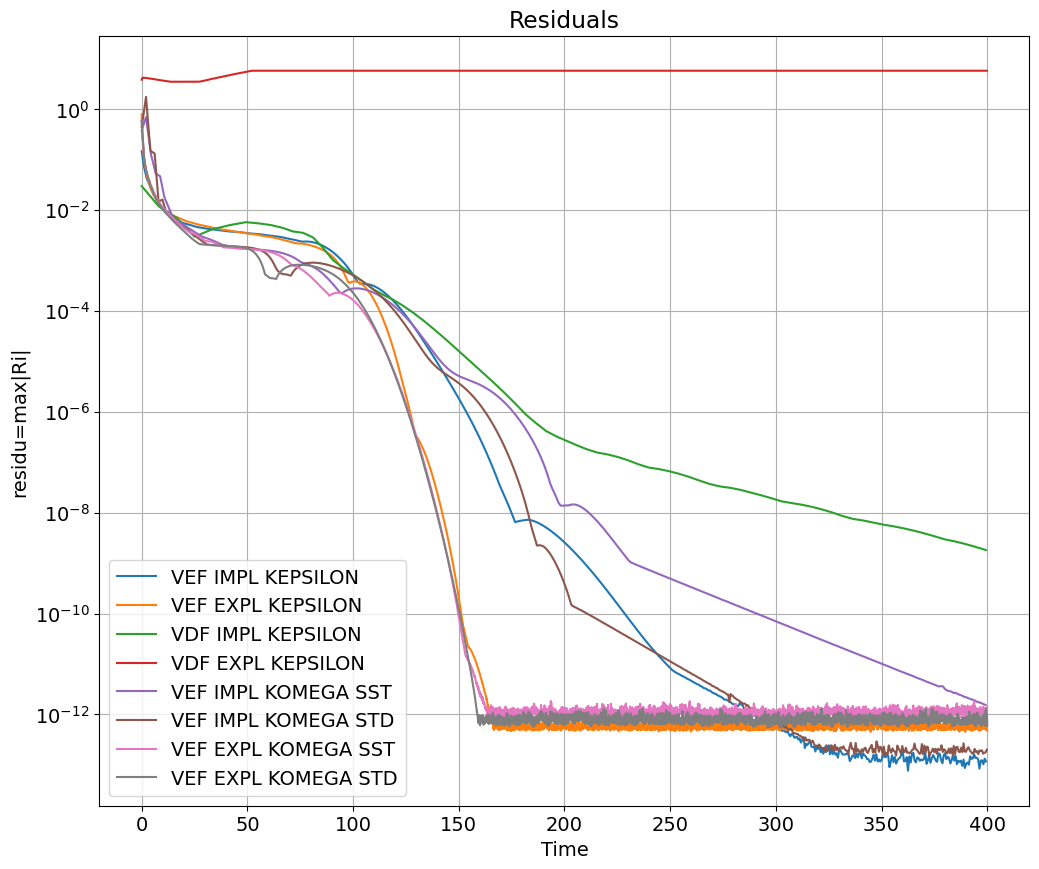

In [27]:
a = plot.Graph("Residuals")

for kdis in ddis.keys():
    for kscheme in dscheme.keys():
        a.addResidu(f"{run.BUILD_DIRECTORY}/{kdis}/{kscheme}/KEPSILON/jdd-kepsilon.dt_ev",
                    label=f"{kdis} {kscheme} KEPSILON ")

kdis = "VEF"
for kscheme in dscheme.keys():
    for modvar in komega_variant:
        a.addResidu(f"{run.BUILD_DIRECTORY}/VEF/{kscheme}/KOMEGA-{modvar}/jdd-komega.dt_ev",
                    label=f"{kdis} {kscheme} KOMEGA {modvar.upper()}")

a.scale(yscale='log')

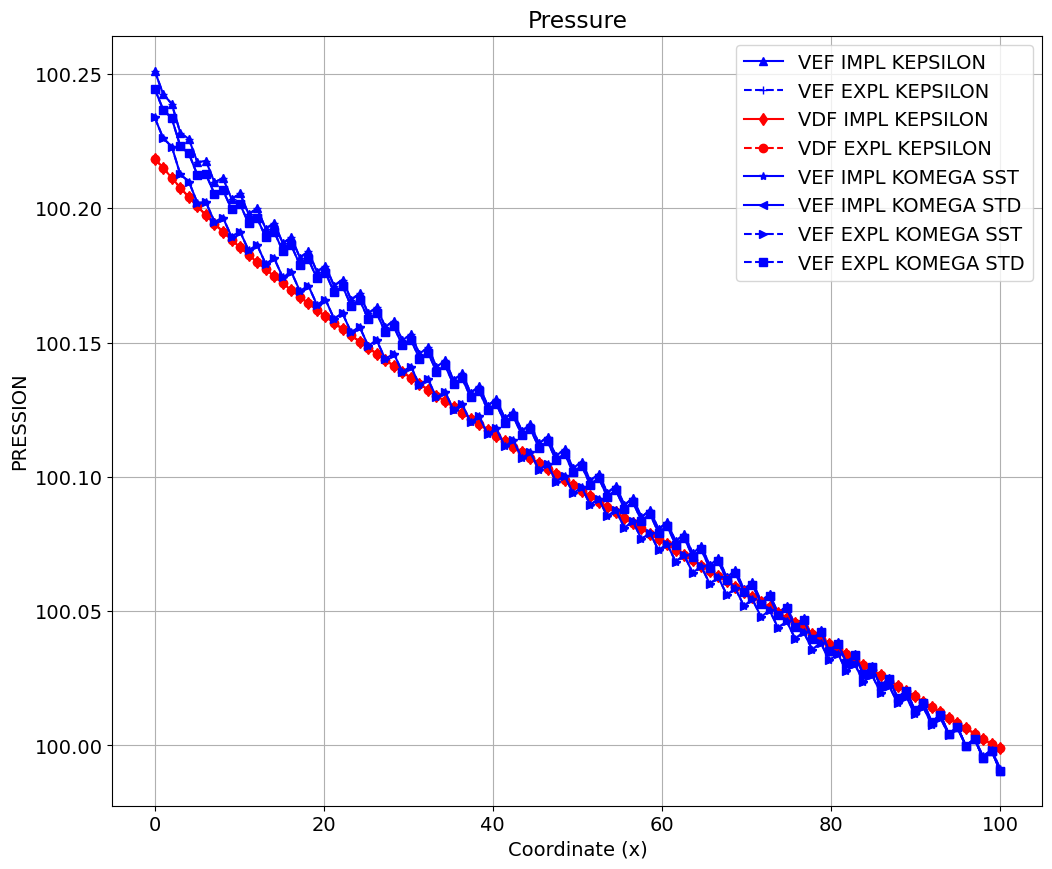

In [23]:
a = plot.Graph("Pressure")

for kdis in ddis.keys():
    for kscheme in dscheme.keys():
        a.addSegment(f"{run.BUILD_DIRECTORY}/{kdis}/{kscheme}/KEPSILON/jdd-kepsilon_PRESSION.son",
                     label=f"{kdis} {kscheme} KEPSILON ",
                     marker = next(marker),
                     color=dcolors[kdis],
                     linestyle=dstyle[kscheme])

for kscheme in dscheme.keys():
    for modvar in komega_variant:
        a.addSegment(f"{run.BUILD_DIRECTORY}/VEF/{kscheme}/KOMEGA-{modvar}/jdd-komega_PRESSION.son",
                     label=f"VEF {kscheme} KOMEGA {modvar.upper()}",
                     marker = next(marker),
                     color=dcolors["VEF"],
                     linestyle=dstyle[kscheme])

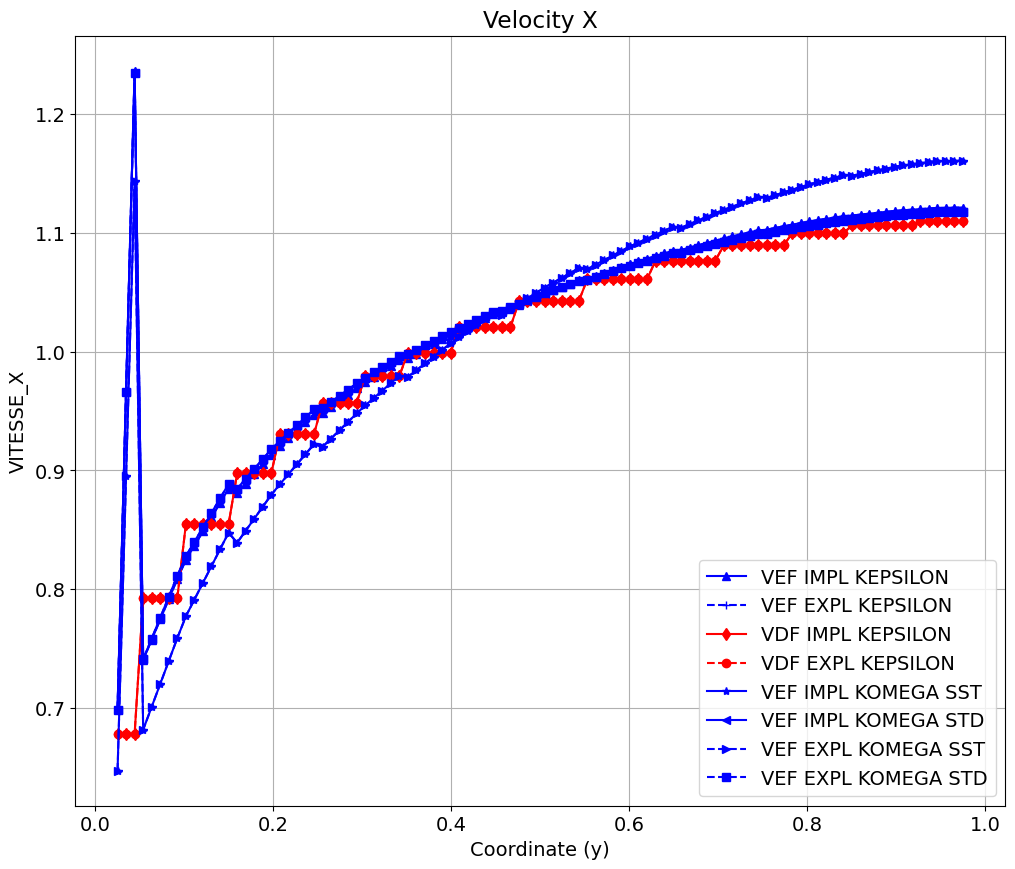

In [24]:
a = plot.Graph("Velocity X")
for kdis in ddis.keys():
    for kscheme in dscheme.keys():
        a.addSegment(f"{run.BUILD_DIRECTORY}/{kdis}/{kscheme}/KEPSILON/jdd-kepsilon_VITESSE.son",
                     compo=0,
                     marker = next(marker),
                     label=f"{kdis} {kscheme} KEPSILON",
                     color=dcolors[kdis],
                     linestyle=dstyle[kscheme])

for kscheme in dscheme.keys():
    for modvar in komega_variant:
        a.addSegment(f"{run.BUILD_DIRECTORY}/VEF/{kscheme}/KOMEGA-{modvar}/jdd-komega_VITESSE.son",
                     compo=0,
                     marker = next(marker),
                     label=f"VEF {kscheme} KOMEGA {modvar.upper()}",
                     color=dcolors["VEF"],
                     linestyle=dstyle[kscheme])

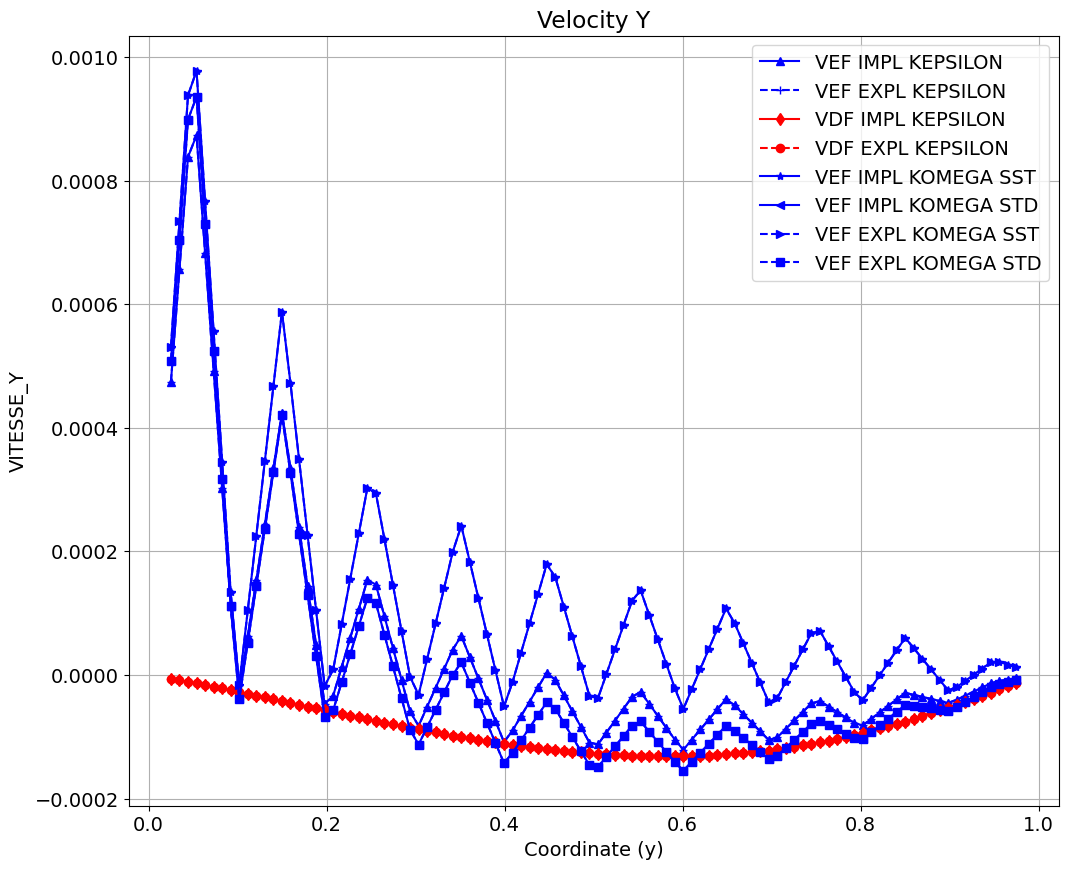

In [25]:
a = plot.Graph("Velocity Y")
for kdis in ddis.keys():
    for kscheme in dscheme.keys():
        a.addSegment(f"{run.BUILD_DIRECTORY}/{kdis}/{kscheme}/KEPSILON/jdd-kepsilon_VITESSE.son",
                     compo=1,
                     marker = next(marker),
                     label=f"{kdis} {kscheme} KEPSILON",
                     color=dcolors[kdis],
                     linestyle=dstyle[kscheme])

for kscheme in dscheme.keys():
    for modvar in komega_variant:
        a.addSegment(f"{run.BUILD_DIRECTORY}/VEF/{kscheme}/KOMEGA-{modvar}/jdd-komega_VITESSE.son",
                     compo=1,
                     marker = next(marker),
                     label=f"VEF {kscheme} KOMEGA {modvar.upper()}",
                     color=dcolors["VEF"],
                     linestyle=dstyle[kscheme])

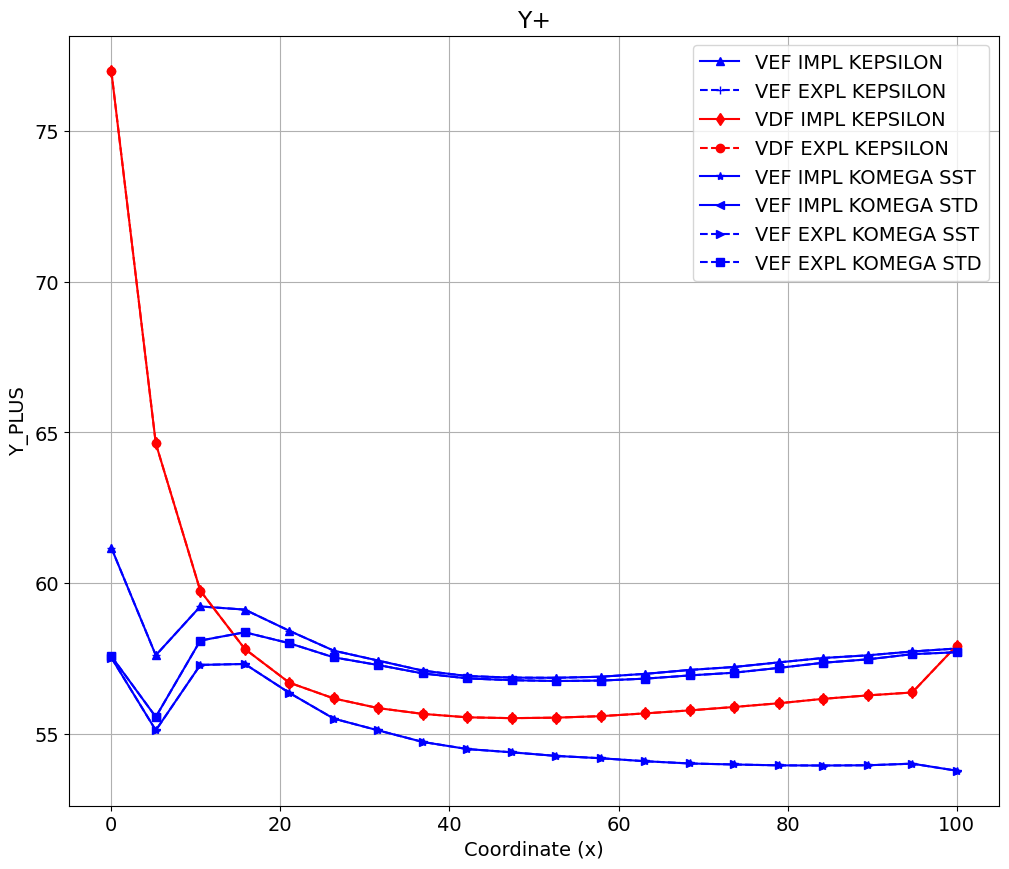

In [26]:
a = plot.Graph("Y+")
for kdis in ddis.keys():
    for kscheme in dscheme.keys():
        a.addSegment(f"{run.BUILD_DIRECTORY}/{kdis}/{kscheme}/KEPSILON/jdd-kepsilon_Y_PLUS.son",
                     marker = next(marker),
                     label=f"{kdis} {kscheme} KEPSILON",
                     color=dcolors[kdis],
                     linestyle=dstyle[kscheme])

for kscheme in dscheme.keys():
    for modvar in komega_variant:
        a.addSegment(f"{run.BUILD_DIRECTORY}/VEF/{kscheme}/KOMEGA-{modvar}/jdd-komega_Y_PLUS.son",
                     marker = next(marker),
                     label=f"VEF {kscheme} KOMEGA {modvar.upper()}",
                     color=dcolors["VEF"],
                     linestyle=dstyle[kscheme])


# TODO
2024-12-12 : This validation form will be extended to VDF for the $k-\omega$ model to have a complete comparison.